# UH-WRRC- ASPA  FloPy model of Tutuila Island

NOTE This model is UNDER DEVELOPMENT and is by no means a finished producct!
### Created by Chris Shuler with support from Katrina Mariner (ASPA) and Aly El-Kadi (UHWRRC). 

basic information about the model and a description of how to run components, modify parameters, and substitute new data.  

### Notebook Set Up. Specify modules and paths. hopefully all modules are installed, if not may need to 
- explore the environment.yml file and see if anything is missing from the environment
- explore the local environments to address any issues
- rebuild the environment with environment.yml or manually 

In [26]:
from IPython.display import display, HTML      # wide screen
display(HTML(data=""" <style>     div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt

GIS_files = os.path.join(".", 'GIS_Data')       # path to the GIS data folder

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('fiona version: {}'.format(fiona.__version__))
print('rasterio version: {}'.format(rasterio.__version__))
print('geopandas version: {}'.format(geopandas.__version__))
print('gdal version: {}'.format(gdal.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('Flo_py_wrkspace')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)

# define some spatial reference objects
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.


3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.16.4
matplotlib version: 3.1.1
flopy version: 3.2.12
fiona version: 1.8.6
rasterio version: 1.0.24
geopandas version: 0.5.1
gdal version: 2.4.1


### Toggles: different options that can be changed

In [27]:
# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

# flag for either using manually entered values for HK or optomized values. once the optimizer is run the flag will change to true and will use the optimiezd set in memory, run this cell to reset 
optimized_flag = False

# toggle this for interactive plots
%matplotlib notebook 
# toggle this for simple plots (nneded for optimization plots)
#%matplotlib inline   

pd.set_option('display.max_rows', 100)    # change number of rows to display if want
np.set_printoptions(suppress=True)       # does anyone else find scientific notation to be annoying?

# Modifieable Groundwater Model Prameters: 
### These can be modified by the user by replacing any number to simuate different conditions 
please note that some parameters or combinations of parameters may create errors or cause the model to not converge. 

In [28]:
# grid size 
ncol = 200       # number of model columns default is 200
nrow = 100       # number of model rows default is 100
nlay = 1         # number of model layers default is 1               ###### Note I need to make t he model able to handle miltiple layers, set up for one right now  #####

# model run times and stress period data
Number_of_years = 300                           # number of years to run the model, other inputs below are scaled off of this number (since default MODFLOW time unit is in days)
nper = 1                                        # Number of model stress periods default is 1
perlen = [365.25*Number_of_years]               # array of the stress period lengths in days separated by commas
nstp = [Number_of_years]                        # Number of time steps in each stress period (default is 1 per year).           
tsmult = 1                                      # Time step multiplier, can be used to make more timesetps at beginning of run, and less at end (use a number just a bit more than 1 like 1.05)
steady = True

# output control parameters
Save_every_how_many_steps = 20                  # essentially used for SWI to save the elevation of the interface every x time steps, defaut is 20
spd = {}
for istp in range(Save_every_how_many_steps-1, nstp[0]+1, Save_every_how_many_steps):   # format the above for modflow 
    spd[(0, istp)] = ['save head', 'print budget']
    spd[(0, istp+1)] = []

# Input Datasets
This cell defines all paths to external input datasets, and thereby provides a list of all model inputs 

In [29]:
# Tutuila coastline polygon Source: AS-DOC GIS portal  (http://portal.gis.doc.as/)  (site currently down) 
TUT_POLY_SHP = os.path.join(GIS_files, 'tut_poly.shp')

# 10 m resolution DEM Source: NOAA (https://data.noaa.gov/dataset/dataset/pago-pago-american-samoa-3-arc-second-mhw-coastal-digital-elevation-model)
DEM10MPRJ1_TIF = os.path.join("..", "..",  'Static_Data_Storage', 'GIS', 'dem10mprj1.tif')

# -50 m bathymetry contour line from DEM. Produced in Arc MAp 
IBOUND_SHP = os.path.join(GIS_files, 'ibound.shp')

# Tutuila coastline polygon Source: AS-DOC GIS portal  (http://portal.gis.doc.as/)  (site currently down) 
TUT_POLY_FOR_GHB_SHP = os.path.join(GIS_files, 'Tut_poly_for_GHB.shp')

# Pre-development water levels spreadsheet. Compiled from drillers logs and pump tests
PREDEVELOP_WLS_2_CSV = os.path.join("..", "..", 'Static_Data_Storage', 'GIS','Predevelop_WLs_2.csv')

# Simplified geologic units. Originally from Stearns, (1944)
SIMPLE_2  = os.path.join(GIS_files, "Simple_2")

# From SWB2 model module in this integrated framework. 
NET_INFILTRATION_ANNUAL_ASC = os.path.join("..", "..", "..", 'ASPA-UH-SWB2_REPO\\output\\post_prcessed_with_MFR\\net_infiltration_annual.asc')  

# monitoring well data from this  integrated framework. 
MON_WELL_MEASUREMENT_SHEET = os.path.join("..", "..", "..",  "ASPA-UH_MonWells", "workspace", "Ave_WL_MSL_m_mon_wells.csv")

### Model geometry definition based on a user supplied shapefile

Shapefile Boundaries: (516771.84375001956, 8410923.999999458, 547311.6875000503, 8425832.999999477)
wrote Flo_py_wrkspace\Model_polyarea.shp
wrote Flo_py_wrkspace\Model_grid.shp


<IPython.core.display.Javascript object>


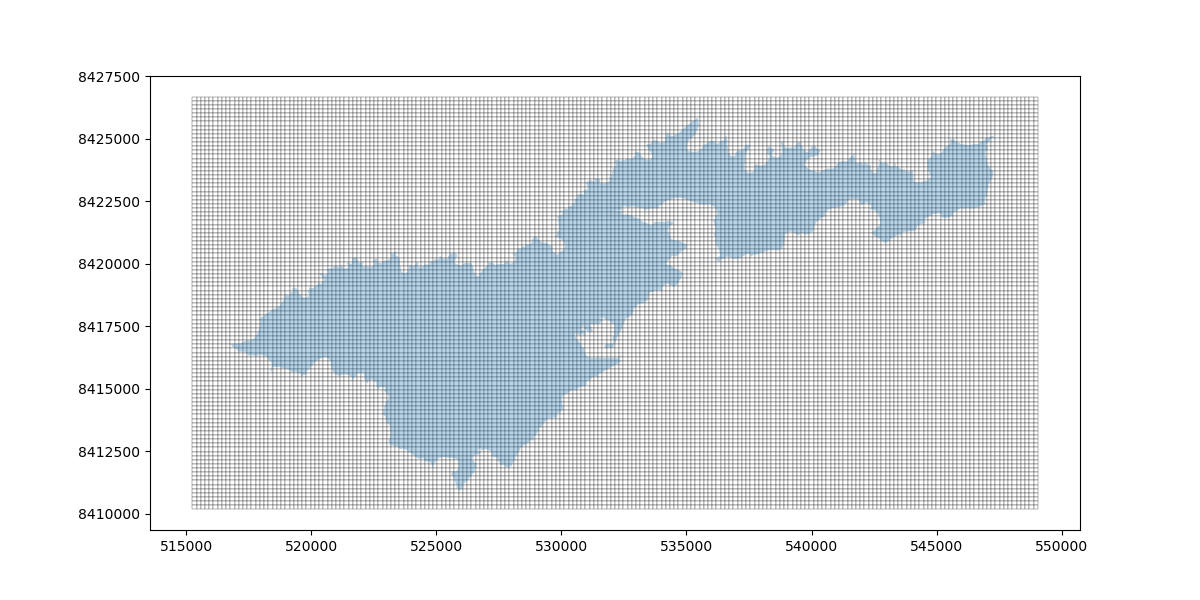

In [30]:
# this inports the boundary shapefile to make the model around
ra = shp2recarray(TUT_POLY_SHP)
# these are the bondaries of the shapefile
shp_xmin = ra.geometry[0].bounds[0]
shp_ymin = ra.geometry[0].bounds[1]
shp_xmax = ra.geometry[0].bounds[2]
shp_ymax = ra.geometry[0].bounds[3]
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))   
#ra.geometry[0].plot() 

xll = int(shp_xmin-(shp_xmax-shp_xmin)*.05)  # Lower left corner of model grid  (note 5% buffer around boundary)
yll = int(shp_ymin-(shp_ymax-shp_ymin)*.05)   # Lower left corner of model grid  (note 5% buffer around boundary)

# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)*(1/(ncol*.9))))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)*(1/(nrow*.9))))   # the height of eech cell

delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc    

rotation = 0      # rotation (positive counterclockwise)


# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(TUT_POLY_SHP)
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)
    plt.savefig(os.path.join(figurespace, "Model_grid.png"))

### Assign Layer elevations all fancy like

<IPython.core.display.Javascript object>


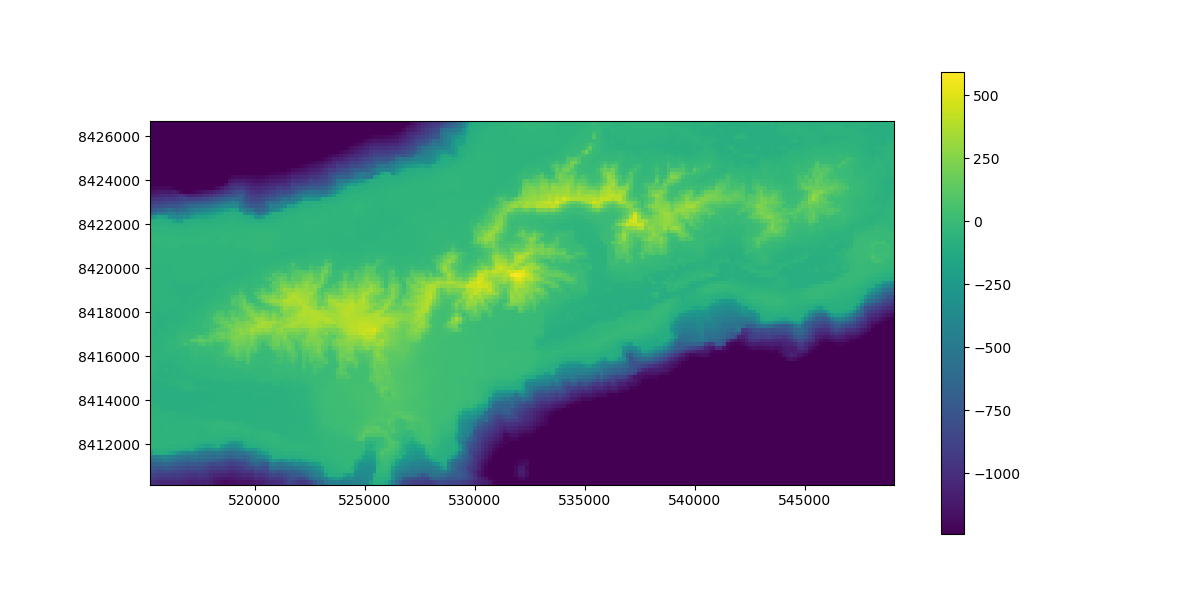

In [31]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = DEM10MPRJ1_TIF
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -1250    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm+10, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)
    plt.savefig(os.path.join(figurespace, "Top_elevations.png"))

## Set up an ibound array with land as active, shelf as specified head and offshore as inactive 

<IPython.core.display.Javascript object>


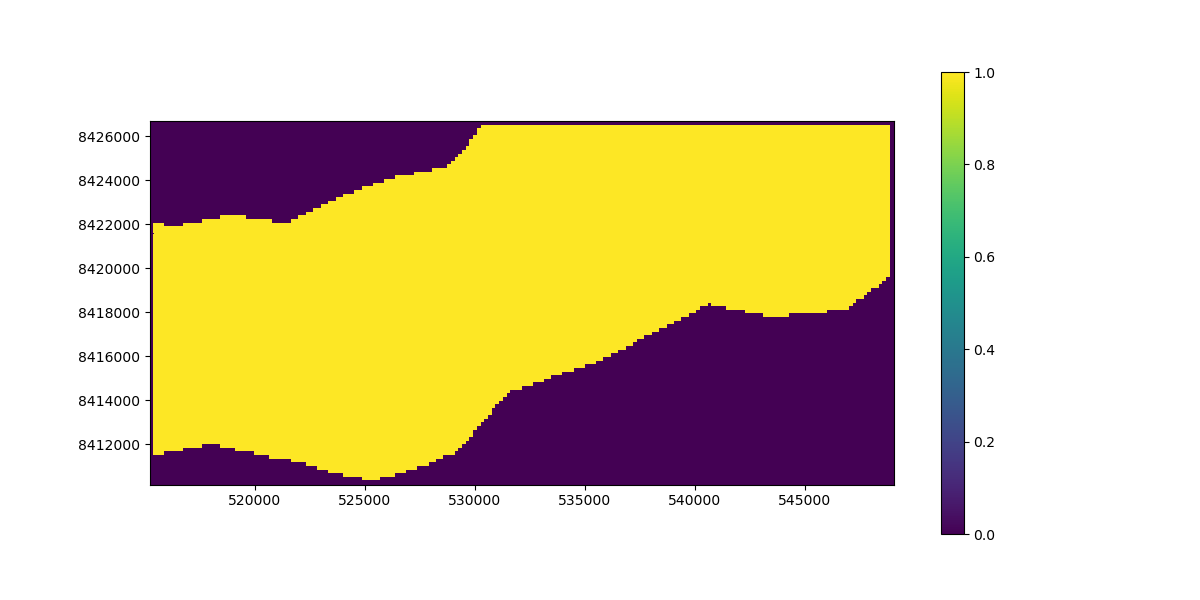

In [7]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(IBOUND_SHP) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['spec_hed'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

# specify initial head 
ihead = np.ones((nlay, nrow, ncol), dtype=np.float)   # ncol
ihead = ihead -.9

#### Use a Tutuila polygon to define the model active area as the island the shelf as specified head, and the offshore as inactive

with fiona.open(TUT_POLY_FOR_GHB_SHP) as src:   #    read in Tutuila shapefile 
    records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['spec_hed']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

Spec_hed_map = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 


# final_ibound = Spec_hed_map + ibound                              # include a specified head boundary condition in addition to GHB  #seems to make the output messy if HK in ocean is high
final_ibound = ibound
final_ibound =  np.where(ibound == -1, 1, final_ibound)           # GHB condition only no specified head

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(final_ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)
    plt.savefig(os.path.join(figurespace, "Ibound.png"))

### GHB boundary condtion definition

This is the general head boundary condition, Little to no user modification needs to be done to this, except for that fact that I dont exactly know how this works, and why it is not keeping the heads in the GHB area consistent at zero or 1 or whatever.  I think I need to do more research into how to use this module and it may need to be modified somewhat. 

<IPython.core.display.Javascript object>


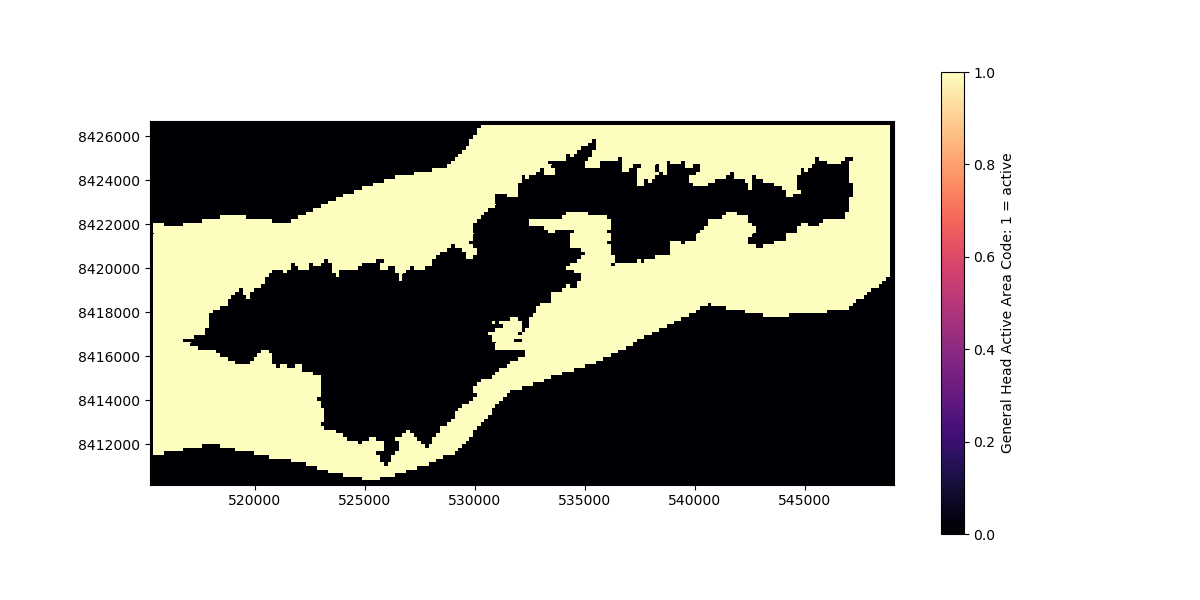

In [32]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells
with fiona.open(IBOUND_SHP) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

GHB_bound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

####Now seting the GHB area  Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells
with fiona.open(TUT_POLY_FOR_GHB_SHP) as src:   #    read in Tutuila shapefile
    records = [r for r in src]   
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Ibound']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)

Inverse_GHBmap = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
neg_array = np.ones((nrow, ncol), dtype=np.int)    # this is the shape array
ghb_geometry = (Inverse_GHBmap+neg_array)*GHB_bound

nghb = np.sum(ghb_geometry)     # this is the total number of General head cells in the model

colcell, rowcell = np.meshgrid(np.arange(0, ncol), np.arange(0, nrow))  # make mesh grid lists of all the dell indexes 

lrchc = np.zeros((nghb, 5))       # layer(int), row(int), column(int), stage(float), conductance(float) array pile this is what ghb package needs
lrchc[:, 0] = 0                                    # give it layer 1
lrchc[:, 1] = rowcell[ghb_geometry == 1]           # assign the specific row numbers for the active ghb cells
lrchc[:, 2] = colcell[ghb_geometry == 1]           # assign the specific col numbers for the active ghb cells
lrchc[:, 3] = .01                                  # this is the starting head value, maybe change to 1?
lrchc[:, 4] = 62.5                   # this is conductance values, probably change later
# create ghb dictionary
ghb_data = {0:lrchc}

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ghb_geometry, ax=ax, cmap = 'magma')
    ax.set_aspect(1)
    plt.colorbar(qm, label = "General Head Active Area Code: 1 = active")
    plt.savefig(os.path.join(figurespace, "GHB.png"))

### Water level Observations
These observations are from a text file in the array inputs folder. New water level observations can simply be added to this text file. 
It would be idea for the user to save the new text file to a new name when adding obaservations, in this case the line below: 
    
    "Unique_frame = pd.read_csv(os.path.join('.',  "Array_inputs", 'Observation_data.txt'))"
    
will need to change to reflect tne new observation file name

<IPython.core.display.Javascript object>


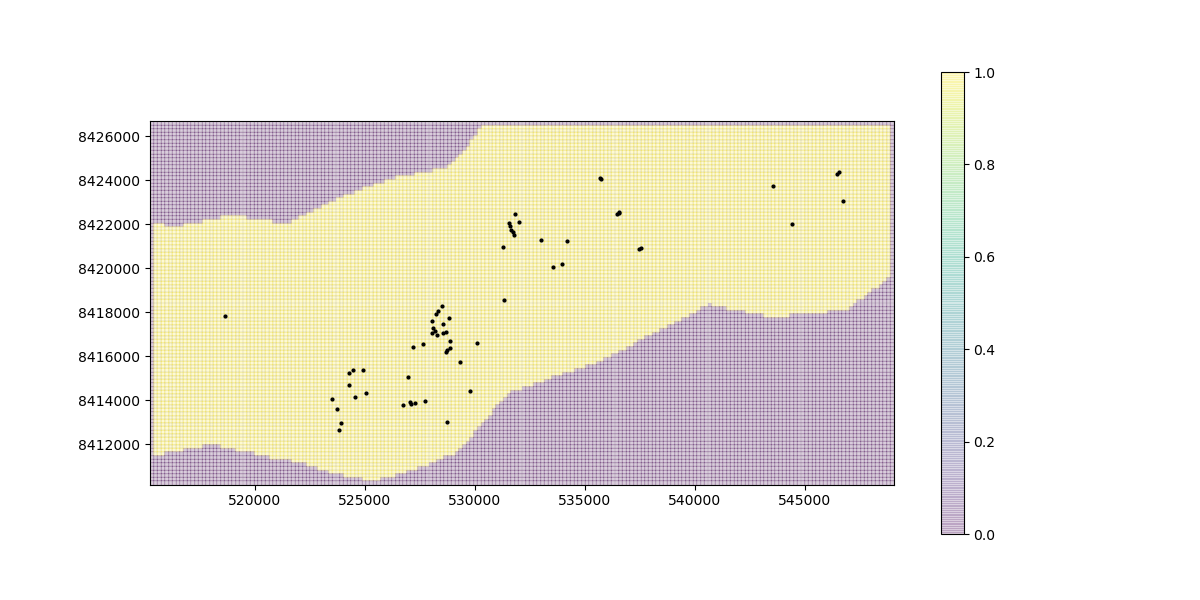

In [33]:
Pdevel_WLs = pd.read_csv(PREDEVELOP_WLS_2_CSV)

# Just stick on the data from the measured monitoring wells (it will average both values if repeated)
Mon_well_WLs = pd.read_csv(MON_WELL_MEASUREMENT_SHEET) 
del Mon_well_WLs['Well_num']
Pdevel_WLs = Pdevel_WLs.append(Mon_well_WLs, sort=False)

Pdevel_WLs['row_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate 
Pdevel_WLs['col_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['col_num'].astype(int))
colvals = list(Unique_WLs['row_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(final_ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)
    plt.savefig(os.path.join(figurespace, "Obs_dots.png"))

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

<IPython.core.display.Javascript object>


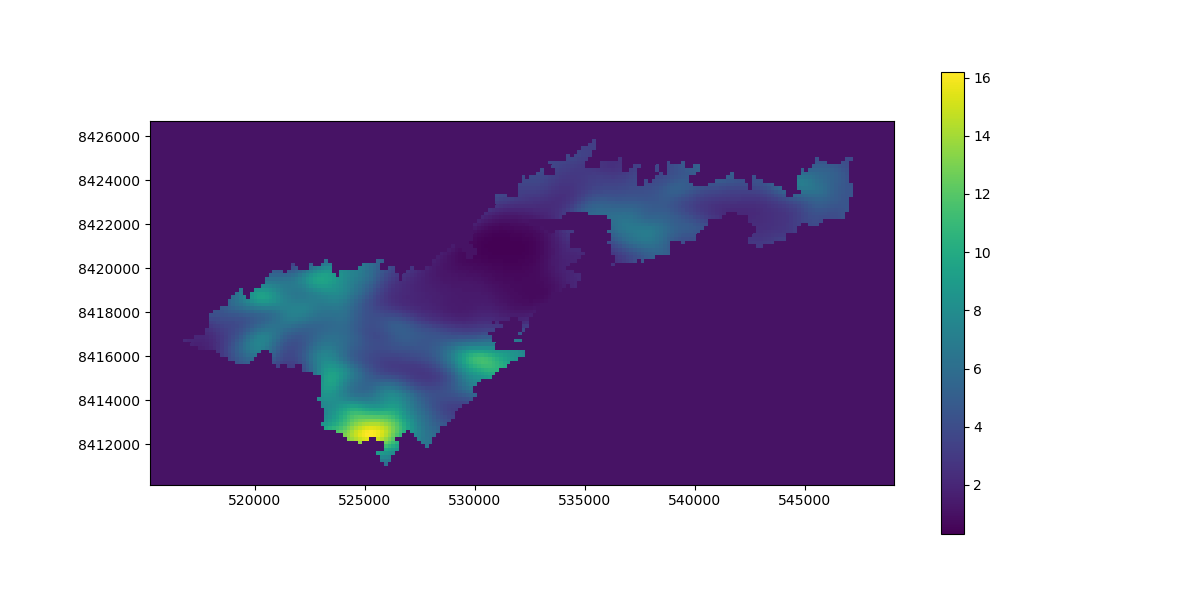

In [105]:
HK_raster = np.loadtxt(os.path.join(".",  "s_hat_adjusted9.txt")) 

mask = ghb_geometry*10000
HK_raster = HK_raster+mask
HK_raster = np.where(HK_raster > 5000, 1,  HK_raster) 

mask = abs(final_ibound-1)*10000
HK_raster = HK_raster+mask
HK_raster = np.where(HK_raster > 5000, 1,  HK_raster) 

HK_raster = HK_raster + 0.1


fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(HK_raster, ax=ax)
ax.set_aspect(1); plt.colorbar(qm)
plt.savefig(os.path.join(figurespace, "HK_Zones.png"))

# lpf data
laytyp = 0
vka = 10

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

<IPython.core.display.Javascript object>


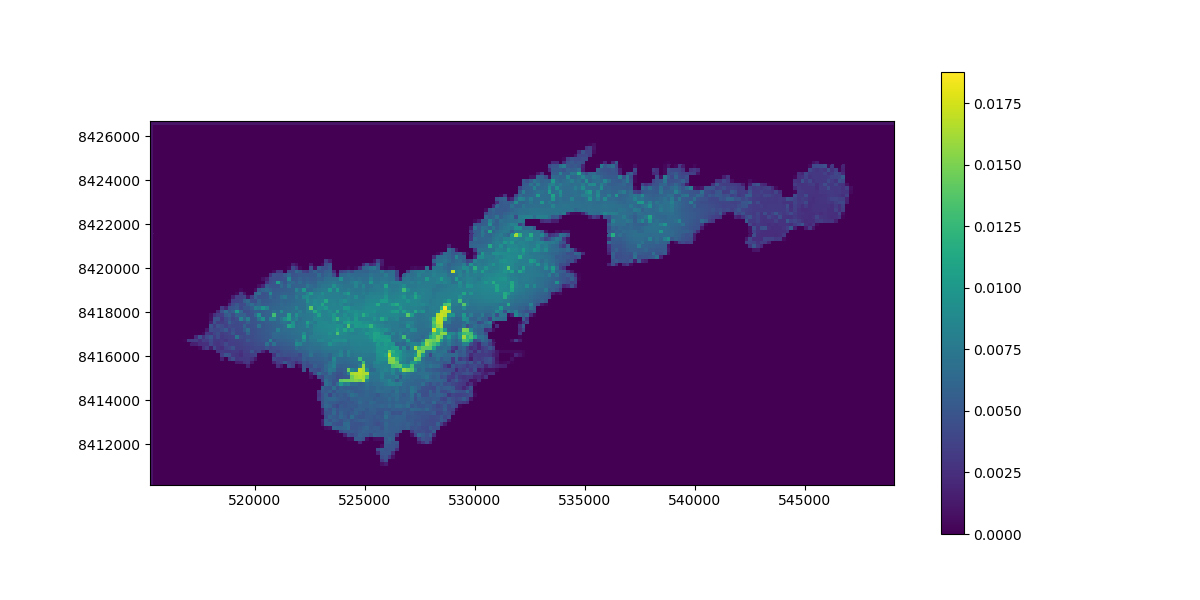

In [106]:
SWB_output_recharge = NET_INFILTRATION_ANNUAL_ASC

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='linear')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)
    plt.savefig(os.path.join(figurespace, "recharge_downsampled.png"))

### SWI saltwater intruction package, basic parameters
References:
- Docs = https://modflowpy.github.io/flopydoc/mfswi2.html?highlight=modflowswi2
- Publication = https://pubs.usgs.gov/tm/6a46/tm6-a46.pdf
- Example notebook 1 = https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_swi2package_ex1.ipynb
- Example notebook 4 = https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_swi2package_ex4.ipynb


<IPython.core.display.Javascript object>


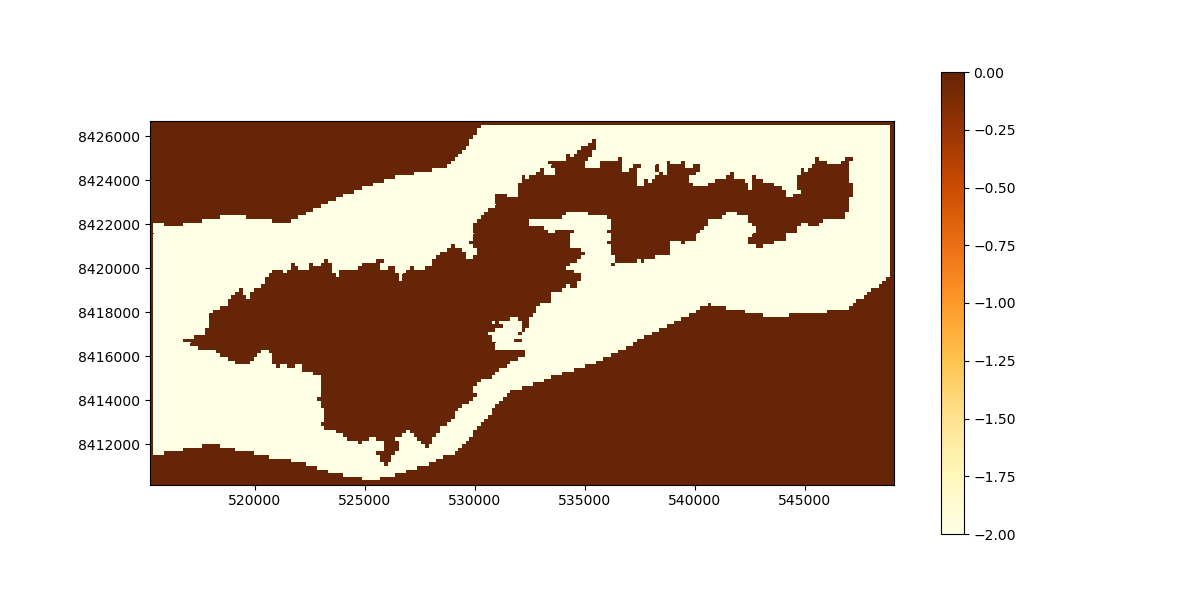

In [89]:
### SWI saltwater intruction package, basic parameters

Make_iso_tricky = Spec_hed_map + ibound

# swi2 data
nadptmx = 10       # user-defined maximum number of SWI2 time steps in any MODFLOW time step.
nadptmn = 1        # the user-defined minimum number of SWI2 time steps in any MODFLOW time step
nu = [0, 0.025]    # dimensionless density at the top of zone 1 and the dimensionless densities of the surface
numult = 5.0                              #Default from example was 5?
toeslope = nu[1] / numult  #0.005
tipslope = nu[1] / numult  #0.005
z1 = 0 * np.ones((nrow, ncol))
z1[final_ibound == 1] = -.5
z = np.array([[z1]])
iso = np.zeros((nlay, nrow, ncol), dtype=np.int)
iso[0][Make_iso_tricky == -1] = -2

ssz=0.02            # effectve porosity

nsrf = 1  # one freshwater zone and one seawater zone, separated by a single (nsrf = 1) active ZETA surface between the zones

istrat = 1   # Represent Fluid density using the stratified option

fig, ax = plt.subplots(figsize = (12,6))
qm = sr.plot_array(iso[0], ax=ax, cmap = 'YlOrBr')
ax.set_aspect(1); plt.colorbar(qm)

## Build model object - pre-prcess all files 

In [107]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp, tsmult=tsmult)

bas = flopy.modflow.ModflowBas(ml, ibound=final_ibound, strt=ihead)

lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)

rch = flopy.modflow.ModflowRch(ml, rech=rch_data)

oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)

pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)

ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)

#SWI package
swi = flopy.modflow.ModflowSwi2(ml, nsrf=nsrf, istrat=istrat , toeslope=toeslope, tipslope=tipslope, 
                                nu=nu,zeta=z, ssz=ssz, isource=iso, nsolver=1,
                                nadptmx=nadptmx, nadptmn=nadptmn, iswizt=55)

# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

In [108]:
ml.check()


modelface MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of

### Run MODFLOW

In [109]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/09/12 17:07:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground-Water Flo

 Solving:  Stress period:     1    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   115    Ground-Wa

 Solving:  Stress period:     1    Time step:   208    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   209    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   210    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   211    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   212    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   213    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   214    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   215    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   216    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   217    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   218    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   219    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   220    Ground-Wa

(True, [])

<IPython.core.display.Javascript object>


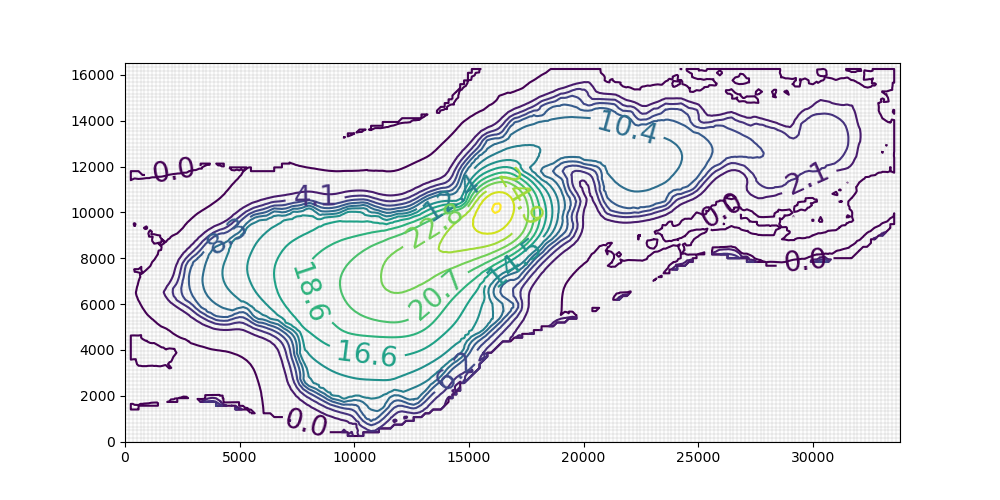

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\flopy\plot\map.py:1356: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


Max head: 29.14m,  min min head -1.61m.


In [110]:
# Post process to graph the results

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

#FV grid extent: (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
#wpt = ((wcol+0.5)*delr, Lx - ((wrow + 0.5)*delc)) # origing at low upper.. b

hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])

##cbb = bf.CellBudgetFile(os.path.join(workspace, '{}.cbc'.format(modelname))) # read budget file
#kstpkper_list = cbb.get_kstpkper()
# cbb.textlist to get a list of data texts
##frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
##fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

# flopy plot object
modelmap = flopy.plot.ModelMap(model=ml, layer=0)
# plot grid
lc = modelmap.plot_grid(alpha=.1) # grid
# plot contour
cs = modelmap.contour_array(head, levels=np.linspace(0, int(head.max()), 15)) # head contour
plt.clabel(cs, fontsize=20, fmt='%1.1f') # contour label
# plot discharge quiver
##quiver = modelmap.plot_discharge(frf, fff, head=head, alpha=.4)
plt.savefig(os.path.join(figurespace, "Head_countours.png"))

plt.show()

print('Max head: {0:1.2f}m,  min min head {1:1.2f}m.'.format(head.max(), (head[head != -999.99]).min()))   # print ma and min head values, and mask out no data values


## Observed vs Simulated plot

<IPython.core.display.Javascript object>


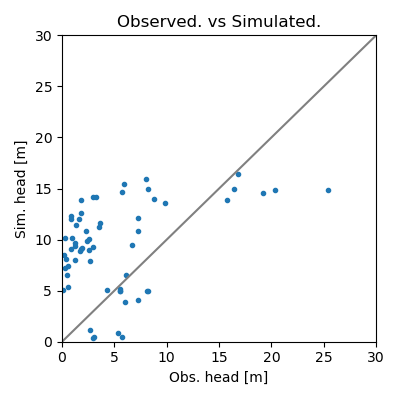

Mean Error: 2.67
Mean Absolute Error: 7.25
RMS Error: 9.74


In [111]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,30)
plt.xlim(0,30)

plt.plot([0,20,30],[0,20,30], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

# plot SWI

In [95]:
# read base model zeta
zfile = flopy.utils.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))   # read the raw data file produced by MODFLOW SWI2
kstpkper = zfile.get_kstpkper()                                                   # Get a list of unique stress periods and time steps in the file (timestep, stress period) 
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])                # turn each surface into an array  Actually a Time x Layer x Col x Row array
zeta = np.array(zeta)

### Plot  E-W cross section

<IPython.core.display.Javascript object>


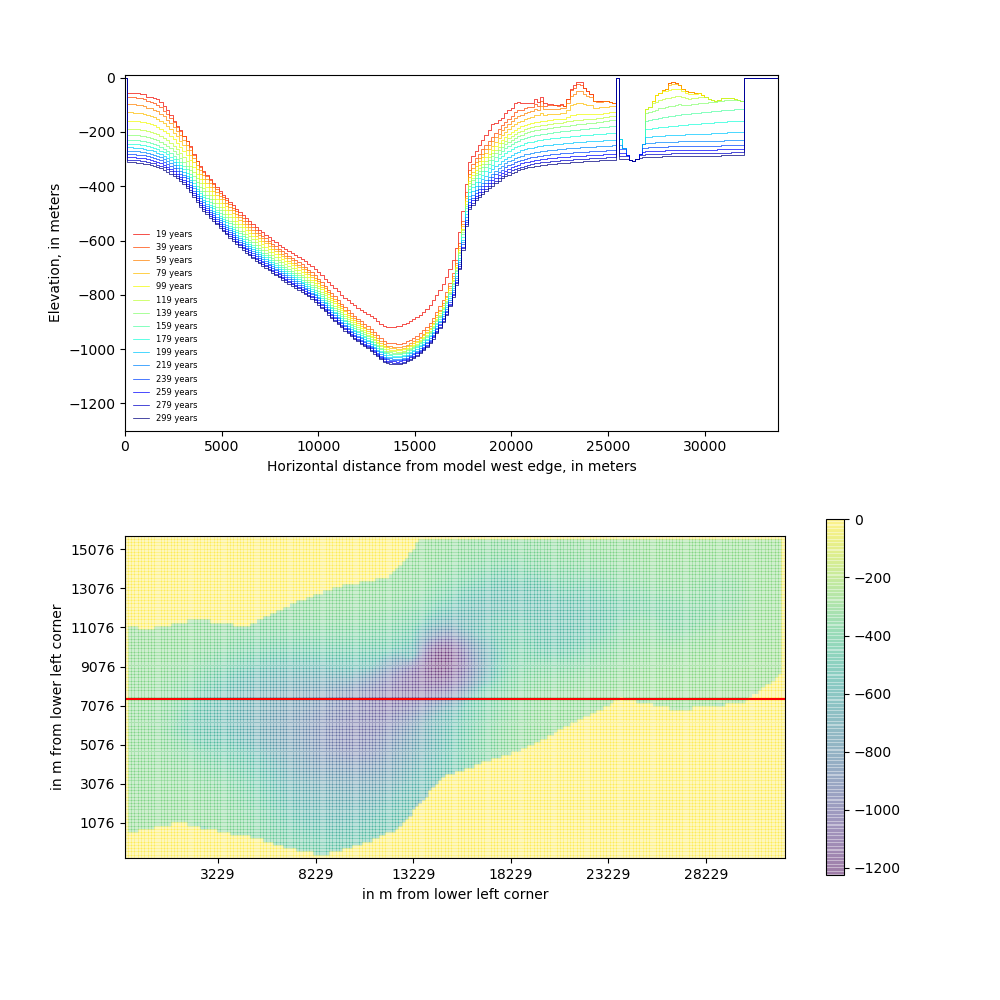

In [96]:
slicerow = 50

plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(10, 10), facecolor='w')
flft, frgt, fbot, ftop = 0.125, 0.95, 0.125, 0.925
fig.subplots_adjust(wspace=0.25, hspace=0.25, left=flft, right=frgt, bottom=fbot, top=ftop)

# Create arrays for cross section plotting the x-coordinates and the output years
xcell = np.linspace(0,ncol*delr,ncol)    

# extract years from the zeta array
years=[]                                      # as long as the time step is a 365.25 multiple of the stress period length otherwise this gets arbitrary!
for idx,val in enumerate(kstpkper):
    printyear = round(kstpkper[idx][0] ,1)
    years.append(printyear)
    
# line color definition  (tricky way to cycle through the colorramp)
icolor = len(years)
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

# plot cross section
ax = plt.subplot2grid((2, 5), (0, 0), colspan=4)       # have to set up many subplot grid spots then span each plot different ammount cuz the colorbar makes it so the bottom plot doesnt line up (this took 1.5 hours of my life)
# axes limits
ax.set_xlim(0, ncol*delr)
ax.set_ylim(-1300, 10)
for idx in range(len(years)):
    ax.plot(xcell, zeta[idx, 0, slicerow, : ], drawstyle='steps-mid',                                # zeta[idx, 0, 50, :] means idx = timestep,  0 is layer 1 , # is row number to plot along, and : is plot all columns 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance from model west edge, in meters')
ax.set_ylabel('Elevation, in meters')


# plan view figure 
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=5)
qm = sr.plot_array(zeta[-1][0], ax=ax2, alpha = .3)

ax2.set_aspect(1); plt.colorbar(qm)
ax2.set_xlabel("in m from lower left corner")
ax2.set_ylabel("in m from lower left corner")
ax2.set_xlim(sr.get_extent()[0], sr.get_extent()[1])
ax2.set_ylim(sr.get_extent()[2], sr.get_extent()[3])


x = np.linspace(0, ncol*delr, ncol)+sr.get_extent()[0]
y = np.ones(ncol)*np.linspace(nrow*delc,0, nrow)[slicerow]+sr.get_extent()[2]

# Scale the axes to have same units as the cross section plot
xtic_vals = ax2.get_xticks()
scale_ax2x = ax2.set_xticklabels(['{:1.0f}'.format(x -516771) for x in xtic_vals])
ytic_vals = ax2.get_yticks()
scale_ax2y = ax2.set_yticklabels(['{:1.0f}'.format(x -8410924) for x in ytic_vals])

if Plotnsave_plot: 
    ax2.plot(x,y, color = 'r')
    plt.show()
    plt.savefig(os.path.join(figurespace, "Horizontal_SWB2.png"))

### Plot  N-S cross section


<IPython.core.display.Javascript object>


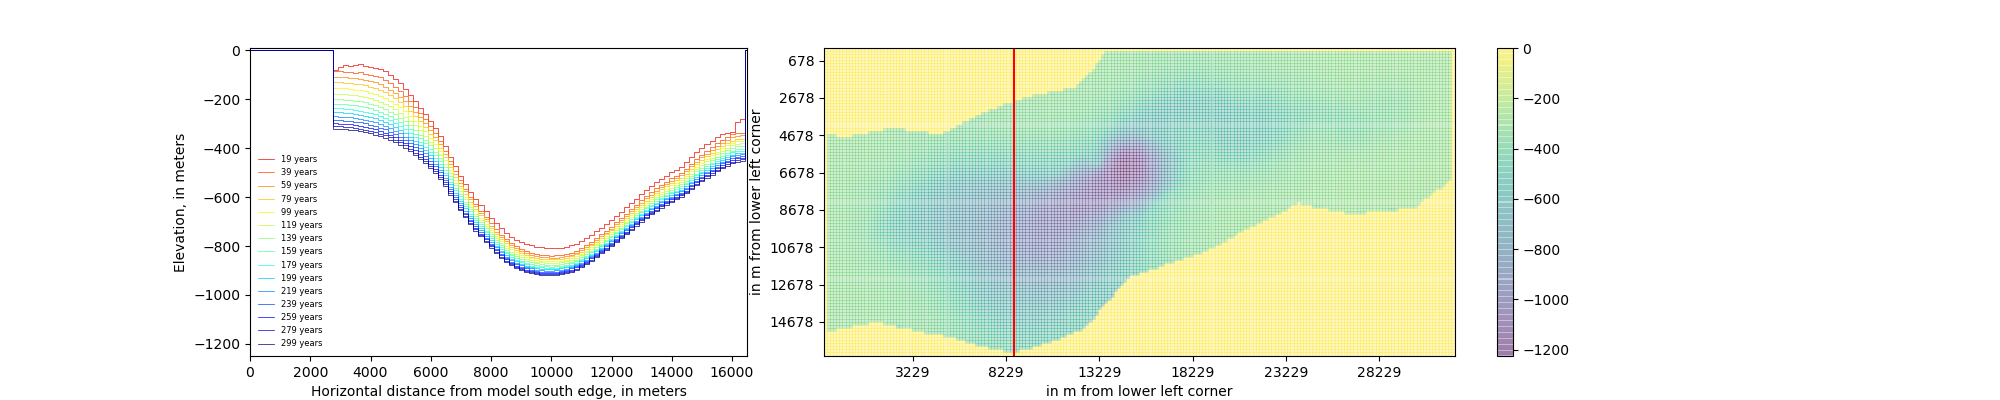

In [97]:
slicecol = 60

plt.rcParams.update({'legend.fontsize': 6, 'legend.frameon' : False})
fig = plt.figure(figsize=(20, 4), facecolor='w')

# Create arrays for cross section plotting the y-coordinates and the output years
#xcell = np.linspace(0,ncol*delr,200)    
xcell = np.linspace(0,nrow*delc,nrow)     

# extract years from the zeta array
years=[]                                      # as long as the time step is a 365.25 multiple of the stress period length otherwise this gets arbitrary!
for idx,val in enumerate(kstpkper):
    printyear = round(kstpkper[idx][0] ,1)
    years.append(printyear)
    
# line color definition  (tricky way to cycle through the colorramp)
icolor = len(years)
colormap = plt.cm.jet  #winter
cc = []
cr = np.linspace(0.9, 0.0, icolor)
for idx in cr:
    cc.append(colormap(idx))

# plot cross section
ax = plt.subplot2grid((1, 9), (0, 0), colspan=3) 
ax.set_xlim(0, nrow*delc)
ax.set_ylim(-1250, 10)
for idx in range(len(years)):
    ax.plot(xcell, zeta[idx, 0, :, slicecol ], drawstyle='steps-mid',                                # zeta[idx, 0, 50, :] means idx = timestep,  0 is layer 1 , # is row number to plot along, and : is plot all columns 
            linewidth=0.5, color=cc[idx], label='{:2d} years'.format(years[idx]))
# legend
plt.legend(loc='lower left')
# axes labels and text
ax.set_xlabel('Horizontal distance from model south edge, in meters')
ax.set_ylabel('Elevation, in meters')


# plan view figure 
ax2 = plt.subplot2grid((1, 9), (0, 3), colspan=5)
qm = sr.plot_array(zeta[-1][0], ax=ax2, alpha = .3)

ax2.set_aspect(1); plt.colorbar(qm)
ax2.set_xlabel("in m from lower left corner")
ax2.set_ylabel("in m from lower left corner")
ax2.set_xlim(sr.get_extent()[0], sr.get_extent()[1])
ax2.set_ylim(sr.get_extent()[2], sr.get_extent()[3])

y = (np.linspace(0, nrow*delc, nrow) )+ sr.get_extent()[2]
x = np.ones(nrow)*np.linspace(0, ncol*delr,ncol)[slicecol]+sr.get_extent()[0]

# Scale the axes to have same units as the cross section plot
xtic_vals = ax2.get_xticks()
scale_ax2x = ax2.set_xticklabels(['{:1.0f}'.format(x -516771) for x in xtic_vals])
ytic_vals = ax2.get_yticks()
scale_ax2y = ax2.set_yticklabels(['{:1.0f}'.format(abs(x -sr.get_extent()[3])) for x in ytic_vals])

if Plotnsave_plot: 
    ax2.plot(x,y, color = 'r')
    plt.show()
    plt.savefig(os.path.join(figurespace, "vertical_SWB2.png"))

<IPython.core.display.Javascript object>


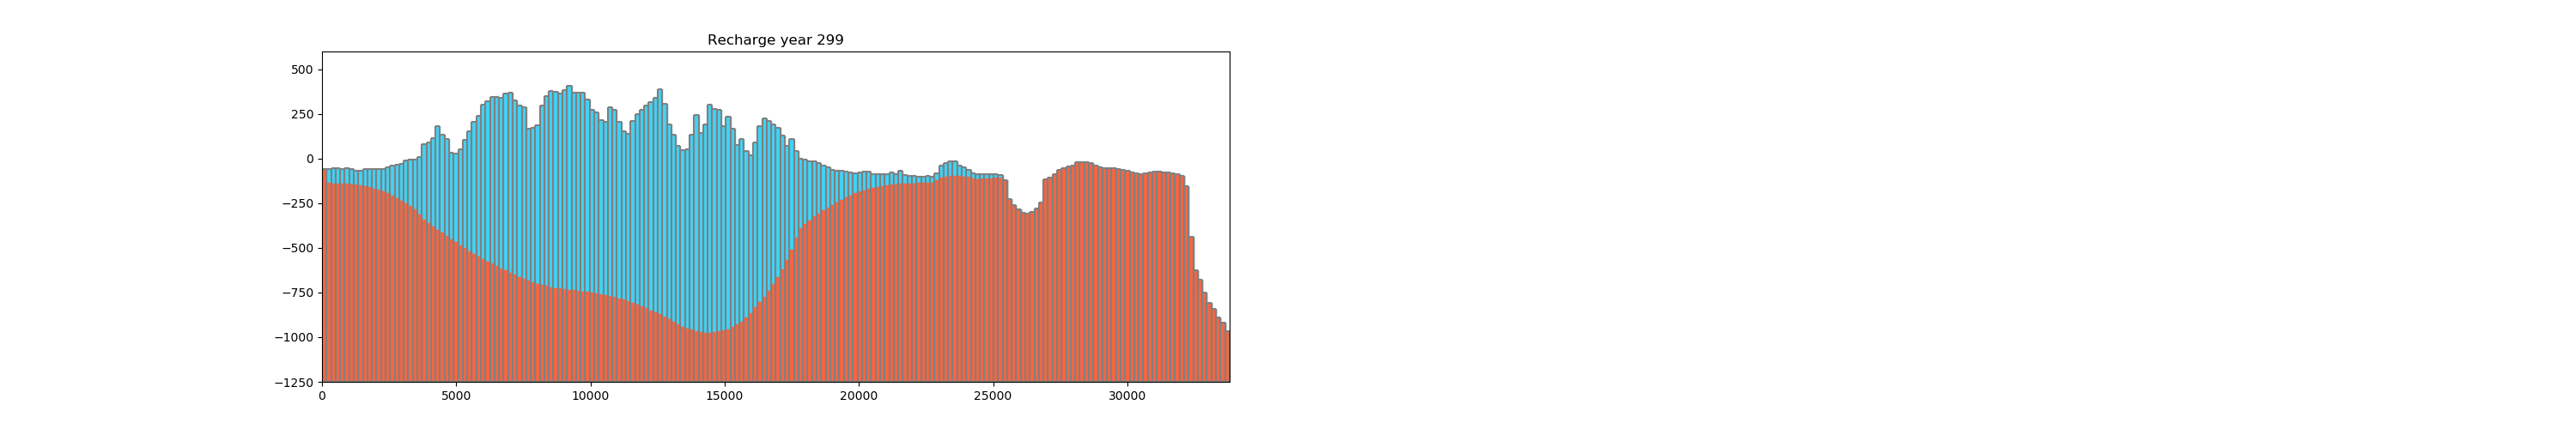

C:\Users\cshuler\Anaconda3\envs\ASPA_Framework\lib\site-packages\flopy\plot\crosssection.py:764: PendingDeprecationWarning: ModelCrossSection will be replaced by PlotCrossSection(), Calling PlotCrossSection()
  warnings.warn(err_msg, PendingDeprecationWarning)


In [86]:
fig = plt.figure(figsize=(30, 5))
colors = ['#40d3f7', '#F76541']

ax = fig.add_subplot(1, 2, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Row': slicerow}, extent=(0, (delr*ncol), -1250, 600))
modelxsect.plot_fill_between(zeta[(np.shape(zeta)[0]-1), :, :, :], colors=colors, ax=ax, edgecolors='none')  
linecollection = modelxsect.plot_grid(ax=ax)
ax.set_title('Recharge year {}'.format(years[np.shape(zeta)[0]-1]));

# Utilities 

### Write a KML file from a projected shapefile 

In [177]:
def poly_shp_to_kml(IN_SHP, OUT_KML, colorstring = "01ff0000"):
    
    tmp = geopandas.GeoDataFrame.from_file(IN_SHP)
    tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
    tmpWGS84.to_file("{}_temp.shp".format(OUT_KML))   
    
    kml = simplekml.Kml(open=1)       # create the kml file
    pfol = kml.newfolder(name="folder")
    openShape = ogr.Open("{}_temp.shp".format(OUT_KML))

    layers = openShape.GetLayerByIndex(0)
    i = 0
    for element in layers:
        geom = loads(element.GetGeometryRef().ExportToWkb())
        i=i+1
        arrcoords = geom.to_wkt()
        pol = pfol.newpolygon() # the part that creates the kml
        pol.style.polystyle.color = colorstring     # 'hexadecimal color string'
        pol.style.polystyle.fill = 0
        pol.style.linestyle.color = "50696969"   
        pol.altitudemode = 'relativeToGround'
        pol.extrude = 1
        coords = arrcoords.replace('POLYGON','').replace('(','').replace(')','')
        coords = coords.replace('MULTI','')
        coords = coords.split(',')
        asize = 1
        pol.outerboundaryis = ([(float(coords[j].split()[0]),float(coords[j].split()[1]),asize) for j in range(len(coords))])

    kml.save(OUT_KML)  # save the kml
    
# from https://publicwiki.deltares.nl/display/OET/From+shape+to+KML

In [ ]:
# Implement     (long run time with small grids)
poly_shp_to_kml(os.path.join(workspace, 'Model_grid.shp'),  os.path.join(figurespace, 'Model_grid.kml') )

### Make Goog-earth point kmls of the Obs Sim and Residuals 

In [ ]:
out_obs_frame = pd.read_csv(os.path.join(workspace, '{}.hob.out'.format(modelname)), sep = "  ", names  = ['Sim_val', 'Obs_val', 'name', 'trash'], skiprows =1, engine='python')
del out_obs_frame['trash']
out_obs_frame = out_obs_frame.merge(Unique_WLs, on ='name', how='inner' )
out_obs_frame['residual'] = out_obs_frame['Sim_val'] - out_obs_frame['Obs_val']

paramaters_list = ['Obs_val', 'Sim_val', 'residual']
colors_list =     ['ff00ff00', 'ffff0000', 'ff0000ff']

def Point_to_kml(paramaters_list, colors_list):

    for idx, val in enumerate(paramaters_list):
        parameter =  val                                                                                     
        p_mean = out_obs_frame[parameter].mean()                                                                      # used for scaling the symbols
        kml = simplekml.Kml()
        for index, row in out_obs_frame.iterrows():                                                                   # iterate over each row
            pnt = kml.newpoint(name=str(round(row[parameter],2)), coords=[( row["Lon"],row["Lat"])])   # change name to row["Sample ID"]  to display just sample id names   
            pnt.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/road_shield3.png'                 # see http://kml4earth.appspot.com/icons.html   for options of symbols
            pnt.iconstyle.color = '70ffffff'                                                                        # Hex color   note forst two digits are transparency last six are the normal hex color digits, see https://www.colorhexa.com/                                     
            pnt.iconstyle.scale = .5                                                                     # apply scaling
            pnt.style.labelstyle.color =  colors_list[idx]    
        kml.save(path = os.path.join(figurespace, "sim_v_obs_{}.kml".format(parameter)))                               # save the kml

In [ ]:
# Implement
Point_to_kml(paramaters_list, colors_list)

### Make Goog-earth overlay kmls of the array inputs

In [ ]:
###### Write a KML overlay from a numpy array input to the model  ######
    
def nparray_to_kml(input_array, out_name, ncol=ncol, nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr]), cmap = plt.cm.jet, **kw):
    
    from osgeo import gdal, osr
    from mpl_toolkits.basemap import Basemap
    from simplekml import (Kml, OverlayXY, ScreenXY, Units, RotationXY, AltitudeMode, Camera)

# turn the numpy array into an asc raster in UTM zone 2S
    the_asc = os.path.join(figurespace, "{}.asc".format(out_name))
    np.savetxt(the_asc, input_array)

    new_first = ('NCOLS {}\n'                        # these are the parameters for the .asc file
                 'NROWS {}\n'
                 'XLLCENTER {}\n'
                 'YLLCENTER {}\n'
                 'CELLSIZE {}\n'
                 'NODATA_value -999.0\n'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))  

    with open(the_asc, 'r+') as file:                # add in new first line and save file  
        file_data = file.read()
        file. seek(0, 0)
        file. write(new_first + '\n' + file_data)
        
        
# turn the new .asc file into a geo-tiff 
    the_tif = os.path.join(figurespace, "{}.tif".format(out_name))
    in_raster = gdal.Open(the_asc)
    gdal.Warp(the_tif ,in_raster, srcSRS='EPSG:{}'.format(model_epsg), dstSRS='EPSG:4326')
    
    
    
# plotting function to plot and format the tif into a Gearth image that doesnt look like crap
    # Note This plotting function is clunky and not very good, but it is the best example I could find so far, probably should do better
    # One of its main issues is that it reads the data upside down and it needs to be flipped with a command, obviously something is wrong
    # from https://gis.stackexchange.com/questions/184727/plotting-raster-maps-in-python
    
    the_png = os.path.join(figurespace, "{}.png".format(out_name))

    ds = gdal.Open(the_tif)              # tif file in
    data = ds.ReadAsArray()

    data = np.flipud(data)    # this is where that sketchy data flip happens

    gt = ds.GetGeoTransform()   
    proj = ds.GetProjection()

    xres = gt[1]
    yres = gt[5]
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    x_center=(xmin+xmax)/2
    y_center=(ymin+ymax)/2  

    m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax, projection='merc', lat_0 = y_center, lon_0 = x_center)
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])
    xx, yy = np.meshgrid(x, y)

    # create the igure object scaled for google earth   from https://ocefpaf.github.io/python4oceanographers/blog/2014/03/10/gearth/
    aspect = np.cos(np.mean([ymin, ymax]) * np.pi/180.0)
    xsize = np.ptp([xmax, xmin]) * aspect
    ysize = np.ptp([ymax, ymin])
    aspect = ysize / xsize

    if aspect > 1.0:
        figsize = (10.0 / aspect, 10.0)
    else:
        figsize = (10.0, 10.0 * aspect)

    if False:

        plt.ioff()  # Make `True` to prevent the KML components from poping-up.
    fig = plt.figure(figsize=figsize,
                     frameon=False,
                     dpi=1024//10)
    # KML friendly image.  If using basemap try: `fix_aspect=False`.
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cs = m.pcolormesh(xx, yy, data, cmap=cmap) # alpha = .9)                              
    fig.savefig(the_png,  transparent=False, format='png', dpi=600)  
    

# this is the save KML overlay part, there are some options in here that can be changed for visualization stuff
    # from https://ocefpaf.github.io/python4oceanographers/blog/2014/03/10/gearth/
    
    the_kml = os.path.join(figurespace, "{}.kmz".format(out_name))
    
    kml = Kml()
    altitude = kw.pop('altitude', 2e4)
    roll = kw.pop('roll', 0)
    tilt = kw.pop('tilt', 0)
    altitudemode = kw.pop('altitudemode', AltitudeMode.relativetoground)
    camera = Camera(latitude=np.mean([ymax, ymin]),
                    longitude=np.mean([xmax, xmin]),
                    altitude=altitude, roll=roll, tilt=tilt,
                    altitudemode=altitudemode)

    kml.document.camera = camera
    draworder = 0
    for fig in [the_png]:  # NOTE: Overlays are limited to the same bbox.
        draworder += 1
        ground = kml.newgroundoverlay(name='GroundOverlay')
        ground.draworder = draworder
        ground.visibility = kw.pop('visibility', 1)
        ground.name = kw.pop('name', 'overlay')
        ground.color = kw.pop('color', '9effffff')
        ground.atomauthor = kw.pop('author', 'ocefpaf')
        ground.latlonbox.rotation = kw.pop('rotation', 0)
        ground.description = kw.pop('description', 'Matplotlib figure')
        ground.gxaltitudemode = kw.pop('gxaltitudemode',
                                       'clampToSeaFloor')
        ground.icon.href = fig
        ground.latlonbox.east = xmin
        ground.latlonbox.south = ymin
        ground.latlonbox.north = ymax
        ground.latlonbox.west = xmax

    # now make a legend for the kml file 
    the_ledg = os.path.join(figurespace, "legend_{}.png".format(out_name))
    
    fig = plt.figure(figsize=(1.5, 4.0), facecolor=None, frameon=False)
    ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
    cb = fig.colorbar(cs, cax=ax)
    cb.set_label(out_name, rotation=-90, color='k', labelpad=20)
    fig.savefig(the_ledg, transparent=True, format='png')  # Change transparent to True if your colorbar is not on space :)

    screen = kml.newscreenoverlay(name='ScreenOverlay')
    screen.icon.href = the_ledg
    screen.overlayxy = OverlayXY(x=0, y=0,
                                 xunits=Units.fraction,
                                 yunits=Units.fraction)
    screen.screenxy = ScreenXY(x=0.015, y=0.075,
                               xunits=Units.fraction,
                               yunits=Units.fraction)
    screen.rotationXY = RotationXY(x=0.5, y=0.5,
                                   xunits=Units.fraction,
                                   yunits=Units.fraction)
    screen.size.x = 0
    screen.size.y = 0
    screen.size.xunits = Units.fraction
    screen.size.yunits = Units.fraction
    screen.visibility = 1

    kmzfile = kw.pop('kmzfile', the_kml) 
    kml.savekmz(the_kml)   

    
# note here are soome mappings that might be useful for this function 
#   xmin,        ymin,        xmax,         ymax
# llcrnrlon,   llcrnrlat,   urcrnrlon,   urcrnrlat 

# reproject existing asc raster to a new coordinate system, not used currently but is part of the above function
#def asc_to_prj_tiff(input_asc, output_tiff, ncol=ncol, nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr])):
#    in_raster = gdal.Open(input_asc)
#    gdal.Warp(output_tiff ,in_raster, srcSRS='EPSG:{}'.format(model_epsg), dstSRS='EPSG:4326') 

In [ ]:
# Implement

# Inputs
nparray_to_kml(top, "topKML")
nparray_to_kml(final_ibound, "final_iboundKML")
nparray_to_kml(HK_raster, "HK_rasterKML")
nparray_to_kml(HK_raster, "HK_rasterKML")
nparray_to_kml(recharge_converted, "recharge_convertedKML")

# outputs
head_plot = head[0]
head_plot = np.where(head_plot < 0, .1, head_plot) # force top elevations to always be higher than bottom elevations
nparray_to_kml(head_plot, "GW_Head", cmap = 'gist_ncar')

## To GMS utilities

Note: to display model in GMS: 
- 1) open up .nam file in GMS. 
- 2) import into GMS with appropriate modflow version (2005 at the moment)
- 3) Open up a coastline shapefile (e.g. tut_poly.shp) in GMS to make sure that it projects correctly, it will prompt to set the display projection
- 4) select 'UTM,  Zone: -2 (174°W - 168°W - Southern Hemisphere), WGS84, meters'
- 5) go to edit -> Transform
- 6) use translate and input value from xll variable (515244.0) and value from yll  (8410178)

In [ ]:
# this is just a little code to export a observation value file for use in GMS. Note to use neeed to open a concept model and obs coverage in GMS then import the OBS_for_GMS_import.csv into that obs coverage.  (dont for get to check heading row)
OBS_4_GMS = Unique_WLs[['x_utm', 'y_utm', 'WL_m_MSL']]
OBS_4_GMS.to_csv(os.path.join(workspace, "OBS_for_GMS_import.csv"))

# Numpy array convert to .asc file

In [ ]:
# take a numpy array from this model and turn it into a .asc raster based on the model geometry dimensions
def nparray_to_asc(input_array, output_raster, ncol=ncol,nrow=nrow, xll=xll, yll=yll, cellsize = np.mean([delc, delr])):

    np.savetxt(output_raster, input_array)

    new_first = ('NCOLS {}\n'                        # these are the parameters for the .asc file
                 'NROWS {}\n'
                 'XLLCENTER {}\n'
                 'YLLCENTER {}\n'
                 'CELLSIZE {}\n'
                 'NODATA_value -999.0\n'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))  

    with open(output_raster, 'r+') as file:                # add in new first line and save file  
        file_data = file.read()
        file. seek(0, 0)
        file. write(new_first + '\n' + file_data)

##  Save countour lines from head plot to a line shapefile 

In [ ]:
from shapely.geometry import mapping, LineString,MultiLineString

outshape_name = os.path.join(figurespace, "Head_contours")             # name the file
schema = {'geometry': 'LineString','properties': {'id': 'int', "hed_val": 'float'}}  # sets up parameters for the shapefile

lines = []  # Empty list for contour sections
for i in range(len(cs.collections)):                            
    p = cs.collections[i].get_paths()[0]                          # for each countour line, read the geometry 
    v = p.vertices 
    x = v[:,0]+xll                                                # need to convert grid based origin to UTM meters
    y = v[:,1]+yll
    line = LineString([(i[0], i[1]) for i in zip(x,y)])           #Defines Linestring of the countour
    lines.append(line)                                            #appends to list
    
with fiona.open(outshape_name+".shp", 'w', 'ESRI Shapefile', schema) as c:  # creates new file to be written to
    for j in range(len(lines)):
        contval = cs.cvalues[j]                                   # extract the head value to write to each feature
        l = (lines[j])                                            # write each line to the shapefile
        c.write({'geometry': mapping(l),'properties': {'id': j, "hed_val": contval},})
        
prj = open(outshape_name+".prj", "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually

##  Save countour lines from Line shapefile to a KML

In [ ]:
def line_shp_to_kml(IN_SHP, OUT_KML):
    tmp = geopandas.GeoDataFrame.from_file(IN_SHP)
    tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})      # convert from UTM projection to WGS84 no projection
    tmpWGS84.to_file("{}_temp.shp".format(OUT_KML))    

    kml = simplekml.Kml(name='Head_contours', open=1)       # create the kml file
    pfol = kml.newfolder(name="folder")
    openShape = ogr.Open("{}_temp.shp".format(OUT_KML))

    layers = openShape.GetLayerByIndex(0)
    i = 0
    for element in layers:                 # cycle over each contour line
        i=i+1
        # write the geometry to kml format
        geom = loads(element.GetGeometryRef().ExportToWkb())
        arrcoords = geom.to_wkt()    
        arrcoords = geom.to_wkt()
        coords = arrcoords.replace('LINESTRING','').replace('(','').replace(')','')
        coords = coords.split(',')
        format_cords = ([(float(coords[j].split()[0]),float(coords[j].split()[1])) for j in range(len(coords))]) # this just formats the coordinates into what linestring wants
        
        hed_val = str(round(element.GetField("hed_val"),1)) +" m"    # get the head value and round it to 1 sig fig 
        lin = pfol.newlinestring(name = hed_val ,coords = format_cords) # the part that creates the kml

        # set the feature labels to show the GW head
        
        lin.style.linestyle.gxlabelvisibility =True    # not sure how to use this et
        lin.style.labelstyle.scale = 1.5  # Make the text twice as big

        # set line color to grade between two different colors    # modified from https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
        c2=np.array(mpl.colors.to_rgb('#ffffff'))  #blue
        c1=np.array(mpl.colors.to_rgb('#800000'))   #red
        hexcolor = mpl.colors.to_hex((1-(i/len(layers)))*c1 + (i/len(layers))*c2)
        hexcolor = hexcolor.replace("#", "ff")
        lin.style.linestyle.color = hexcolor     # 'hexadecimal color string'

        # other random display parameters
        lin.altitudemode = 'clampToGround'
        lin.extrude = 1   
        lin.visibility = 50
        lin.style.linestyle.width = 3  # number of pixels

    kml.save(OUT_KML)
    

In [ ]:
line_shp_to_kml(outshape_name+".shp", outshape_name+".kml")

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
# currently not used functions 

# sometimes Flopy is annoying and prints too much stuff. This function hides printouts   to use just so somenthing in an indented block under "with HiddenPrints():"
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
        
        
        
        
        

##  Save countour lines from head plot to a Polygon shapefile 
        
from shapely.geometry import mapping, Polygon

outshape_name = os.path.join(figurespace, "contours_poly")             # name the file
schema = {'geometry': 'Polygon','properties': {'id': 'int', "hed_val": 'float'}}  # sets up parameters for the shapefile

gons = []  # Empty list for contour sections
for i in range(len(cs.collections)):                            
    p = cs.collections[i].get_paths()[0]                          # for each countour line, read the geometry 
    v = p.vertices 
    x = v[:,0]+xll                                                # need to convert grid based origin to UTM meters
    y = v[:,1]+yll
    poly = Polygon([(i[0], i[1]) for i in zip(x,y)])              #Defines Ploygon of the countour
    line = LineString([(i[0], i[1]) for i in zip(x,y)])           
    gons.append(poly)                                            #appends to list
    
with fiona.open(outshape_name+".shp", 'w', 'ESRI Shapefile', schema) as c:  # creates new file to be written to
    for j in range(len(gons)):
        contval = cs.cvalues[j]                                   # extract the head value to write to each feature
        l = (gons[j])                                            # write each line to the shapefile
        c.write({'geometry': mapping(l),'properties': {'id': j, "hed_val": contval},})
        
prj = open(outshape_name+".prj", "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually

In [ ]:
optimized_flag = True